## Name: Shivanand Satyappa Nashi

## Quantium Virtual Internship - Retail Strategy and Analytics

## Task:
Our client has asked us to evaluate the performance of a store trial which was performed in stores 77, 86 and 88.

This can be broken down by:

total sales revenue total number of customers average number of transactions per customer

Create a measure to compare different control stores to each of the trial stores to do this write a function to reduce having to re-do the analysis for each trial store. Consider using Pearson correlations or a metric such as a magnitude distance e.g. 1- (Observed distance – minimum distance)/(Maximum distance – minimum distance) as a measure.

Once you have selected your control stores, compare each trial and control pair during the trial period. You want to test if total sales are significantly different in the trial period and if so, check if the driver of change is more purchasing customers or more purchases per customers etc.

# Solution:

## Import libraries and Loading dataset

In [1]:
import pandas as pd
import numpy as np

# for data visualization 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import pearsonr, ttest_ind

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load and prepare the dataset
file_path = 'QVI_data.csv'
qvi_data = pd.read_csv(file_path)

# Checking the dataset

In [3]:
qvi_data.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [4]:
qvi_data.columns

Index(['LYLTY_CARD_NBR', 'DATE', 'STORE_NBR', 'TXN_ID', 'PROD_NBR',
       'PROD_NAME', 'PROD_QTY', 'TOT_SALES', 'PACK_SIZE', 'BRAND', 'LIFESTAGE',
       'PREMIUM_CUSTOMER'],
      dtype='object')

In [5]:
qvi_data.shape

(264834, 12)

In [6]:
qvi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


In [7]:
qvi_data.describe().T

,count,mean,std,min,25%,50%,75%,max
LYLTY_CARD_NBR,264834.0,135548.793331,80579.898912,1000.0,70021.0,130357.0,203094.00,2373711.0
STORE_NBR,264834.0,135.079423,76.784063,1.0,70.0,130.0,203.00,272.0
TXN_ID,264834.0,135157.623236,78132.920436,1.0,67600.5,135136.5,202699.75,2415841.0
PROD_NBR,264834.0,56.583554,32.826444,1.0,28.0,56.0,85.00,114.0
PROD_QTY,264834.0,1.905813,0.343436,1.0,2.0,2.0,2.00,5.0
TOT_SALES,264834.0,7.299346,2.527241,1.5,5.4,7.4,9.20,29.5
PACK_SIZE,264834.0,182.425512,64.325148,70.0,150.0,170.0,175.00,380.0


# Data Cleaning and Preparation

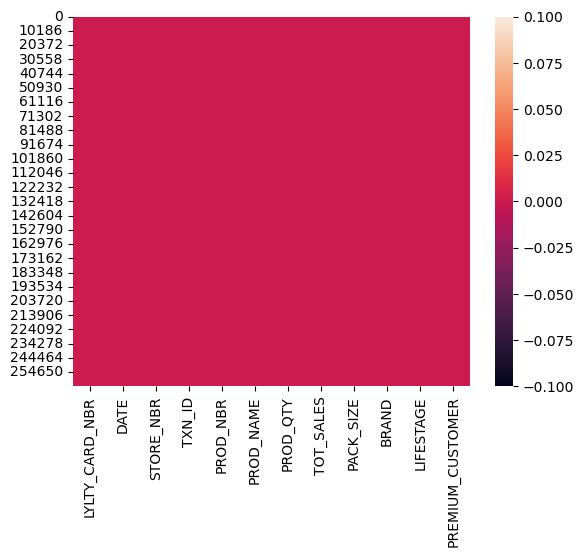

In [8]:
### Checking missing values of QVI_purchase_behaviour data
sns.heatmap(qvi_data.isnull())
plt.show()

In [9]:
qvi_data.isnull().sum()

LYLTY_CARD_NBR      0
DATE                0
STORE_NBR           0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
PACK_SIZE           0
BRAND               0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

In [10]:
qvi_data = qvi_data.dropna(subset=['STORE_NBR', 'TOT_SALES', 'DATE'])
qvi_data['DATE'] = pd.to_datetime(qvi_data['DATE'])
qvi_data['MONTH'] = qvi_data['DATE'].dt.to_period('M')

In [11]:
# Filter trial and control stores
trial_stores = [77, 86, 88]
control_stores = [233, 89, 168]
filtered_data = qvi_data[qvi_data['STORE_NBR'].isin(trial_stores + control_stores)]

In [12]:
# Calculate monthly metrics
monthly_metrics = filtered_data.groupby(['STORE_NBR', 'MONTH']).agg(
    total_sales=('TOT_SALES', 'sum'),
    total_customers=('LYLTY_CARD_NBR', 'nunique'),
    total_transactions=('TXN_ID', 'count')
).reset_index()

monthly_metrics['avg_txn_per_customer'] = (
    monthly_metrics['total_transactions'] / monthly_metrics['total_customers']
)

In [13]:
# Analysis Function
def analyze_stores(trial_store, control_store, metrics_df):
    trial_data = metrics_df[metrics_df['STORE_NBR'] == trial_store]
    control_data = metrics_df[metrics_df['STORE_NBR'] == control_store]
    
    common_months = set(trial_data['MONTH']).intersection(control_data['MONTH'])
    trial_data = trial_data[trial_data['MONTH'].isin(common_months)]
    control_data = control_data[control_data['MONTH'].isin(common_months)]
    
    trial_sales = trial_data['total_sales']
    control_sales = control_data['total_sales']
    
    customer_corr, _ = pearsonr(trial_data['total_customers'], trial_data['total_sales'])
    t_stat, p_value = ttest_ind(trial_sales, control_sales, equal_var=False)
    sales_correlation = trial_data[['total_customers', 'avg_txn_per_customer']].corrwith(trial_data['total_sales'])
    
    return {
        'sales_comparison': {'trial_total': trial_sales.sum(), 'control_total': control_sales.sum()},
        'customer_sales_correlation': customer_corr,
        't_test': {'t_stat': t_stat, 'p_value': p_value},
        'sales_influence_factors': sales_correlation,
    }

In [14]:
# Example Analysis
results = analyze_stores(77, 233, monthly_metrics)

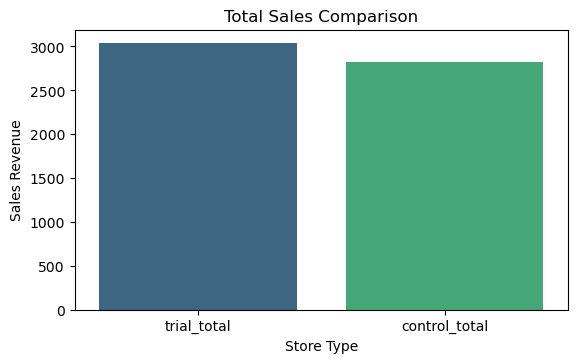

In [15]:
# Visualization
plt.figure(figsize=(14, 8))

# Subplot 1: Sales Comparison
plt.subplot(2, 2, 1)
sns.barplot(
    x=list(results['sales_comparison'].keys()),
    y=list(results['sales_comparison'].values()),
    palette='viridis',
    hue=None  
)
plt.title('Total Sales Comparison')
plt.ylabel('Sales Revenue')
plt.xlabel('Store Type')
plt.show()

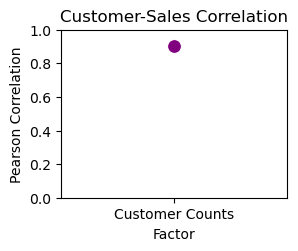

In [16]:
# Subplot 2: Customer-Sales Correlation
plt.subplot(2, 2, 2)
sns.scatterplot(x=['Customer Counts'], y=[results['customer_sales_correlation']], s=100, color='purple')
plt.title('Customer-Sales Correlation')
plt.ylim(0, 1)
plt.ylabel('Pearson Correlation')
plt.xlabel('Factor')
plt.show()

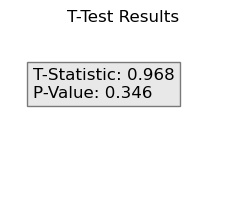

In [17]:
# Subplot 3: T-Test Results
plt.subplot(2, 2, 3)
plt.text(
    0.1, 0.6,
    f"T-Statistic: {results['t_test']['t_stat']:.3f}\nP-Value: {results['t_test']['p_value']:.3f}",
    fontsize=12,
    bbox=dict(facecolor='lightgrey', alpha=0.5)
)
plt.title('T-Test Results')
plt.axis('off')
plt.show()

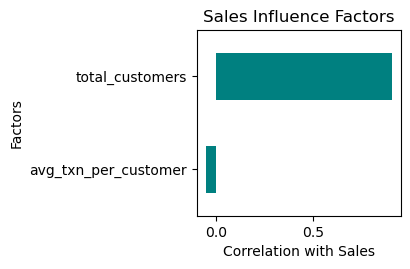

In [18]:
# Subplot 4: Sales Influence Factors
plt.subplot(2, 2, 4)
results['sales_influence_factors'].sort_values().plot(kind='barh', color='teal')
plt.title('Sales Influence Factors')
plt.xlabel('Correlation with Sales')
plt.ylabel('Factors')

plt.tight_layout()
plt.show()

#Results and Findings:
Total Sales Comparison: The bar plot compares total sales revenue between the trial store (trial_total) and the control store (control_total).

#  Subplot 1 Observation:
1. The trial store's total sales 3040 are slightly higher than the control store's total sales 2827. This suggests that the trial store might have experienced a sales boost, but further analysis (like statistical significance) is needed to confirm.
2. Customer-Sales Correlation: This scatter plot displays the Pearson correlation coefficient 0.903 between customer counts and total sales for the trial store.

# Subplot 2 Observation:
A high positive correlation (close to 1) suggests that increasing customer counts significantly drives sales revenue for the trial store. 3. T-Test Results: This text box displays the results of a T-Test comparing sales between the trial and control stores: T-Statistic: 0.968 P-Value: 0.346

# Subplot 3 Observation:
The p-value (0.346) is much greater than the typical significance threshold (0.05), indicating that the difference in sales between the trial and control stores is not statistically significant. Therefore, the observed difference might be due to chance. 4. Sales Influence Factors: A horizontal bar plot shows the correlation of two factors with sales for the trial store: total_customers: 0.903 (strong positive correlation) avg_txn_per_customer: -0.05 (weak negative correlation)

# Subplot 4 Observation:
Sales are strongly influenced by the number of customers, whereas the average number of transactions per customer has a negligible and slightly negative effect.

# Summary of Insights:

## Trial Store Performance:
Sales are slightly higher in the trial store compared to the control store, but the difference is not statistically significant.

## Key Driver of Sales:
The increase in customer counts is the primary factor influencing sales performance. Efforts to drive sales should focus on attracting more customers rather than increasing transactions per customer.

## Statistical Significance:
The lack of statistical significance suggests that the observed differences might not be attributable to the trial intervention. This analysis provides actionable insights for strategizing sales improvement initiatives.